# Семинар 1: Generative Adversarial Networks

## Вступление
Одно из самых известных семейств архитектур, применяемых для генеративных задач в разных доменах, — это, конечно же, generative adversarial networks (GAN). GAN обычно состоит из двух сетей: генератора и дискриминатора. Дискриминатор пытается отличить сгенерированные объекты от реальных. Генератор пытается обмануть дискриминатор и сгенерировать такие объекты, которые он не сможет отличить от настоящих. Задача, которую решают сети, является минимаксной (одна сеть пытается минимизировать функционал, а другая максимизировать) и её точка равновесия достигается, когда генератор выдает объекты, полностью не отличимые от настоящих. Сегодня мы посмотрим примеры кода, реализующих GAN.

### План семинара
1. Реализуем GAN для двумерных данных
2. Применяем GAN для MNIST
3. Смотрим на сломанный GAN и пытаемся понять, почему так вышло

In [1]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from sklearn import datasets
from torch import nn, optim
from torchvision.datasets import MNIST
from typing_extensions import Literal

%matplotlib inline
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## 1. Vanilla GAN: двумерные данные

Для Vanilla GAN функционал имеет следующий вид:

$L(D, G) = - \frac1n \sum_{x_i \in X} \log D(x_i) - \frac1n \sum_{z_i \in N(0, 1)} \log (1 - D(G(z_i))) \rightarrow \min_{D} \max_{G}$

На практике, дискриминатор и генератор обучают не одновременно, а чередуют $n$ шагов оптимизации _только_ генератора и $m$ шагов оптимизации _только_ дискриминатора. В случае Vanilla GAN, эмпирически получается лучше, когда дискриминатор обучается больше шагов, чем генератор. $n$ и $m$ являются гиперпараметрами и подбираются под задачу архитектуры генератора и дискриминатора.

Для подсчета лосса лучше не считать логарифм сигмоиды, а использовать функцию logsigmoid для подсчета обеих частей, работая напрямую с логитами дискриминатора. В случае $\log (1 - D(G(z_i)))$ можно воспользоваться свойством $1 - \sigma(x) = \sigma(-x)$.

Процесс обучения GAN'а выглядит так:

In [2]:
def gan_loss(
    real_objects_scores: torch.Tensor,
    generated_objects_scores: torch.Tensor,
    by: Literal["generator", "discriminator"] = "generator",
) -> torch.Tensor:
    if by == "generator":
        return torch.log(1 - generated_objects_scores).mean()
    elif by == "discriminator":
        return (
            -torch.log(real_objects_scores).mean()
            - torch.log(1 - generated_objects_scores).mean()
        )


def train_gan(
    tr_dataloader,
    gen,
    discr,
    gen_opt,
    discr_opt,
    loss_func,
    prior,
    num_epochs,
    gen_steps,
    discr_steps,
    verbose_num_iters=100,
    data_type="2d",
):
    gen.train()
    discr.train()
    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):
        print(f"Epoch {epoch_i + 1}")
        for batch in tr_dataloader:
            # берем реальные объекты
            real_objects, _ = batch
            real_objects = real_objects.to(device)

            # генерируем новые объекты
            num_objects = real_objects.shape[0]
            z = prior.sample((num_objects,))
            gen_objects = gen(z)

            # считаем скоры
            real_objects_scores, gen_objects_scores = torch.split(
                discr(torch.cat([real_objects, gen_objects], dim=0)),
                num_objects,
            )

            if (iter_i % (gen_steps + discr_steps)) < gen_steps:
                # делаем шаг обучения генератора
                gen_opt.zero_grad()
                gen_loss = loss_func(
                    real_objects_scores, gen_objects_scores, "generator"
                )
                gen_loss.backward()
                gen_opt.step()
                gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
                # делаем шаг обучения дискриминатора
                discr_opt.zero_grad()
                discr_loss = loss_func(
                    real_objects_scores, gen_objects_scores, "discriminator"
                )
                discr_loss.backward()
                discr_opt.step()
                discr_loss_trace.append((iter_i, discr_loss.item()))

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 3, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Generator loss")
                plt.plot([p[0] for p in gen_loss_trace], [p[1] for p in gen_loss_trace])

                plt.subplot(1, 3, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Discriminator loss")
                plt.plot(
                    [p[0] for p in discr_loss_trace],
                    [p[1] for p in discr_loss_trace],
                    color="orange",
                )

                gen.eval()
                if data_type == "2d":
                    plt.subplot(1, 3, 3)
                    with torch.no_grad():
                        z = prior.sample((1024,))
                        sampled_2d = gen(z)
                    x = real_objects.cpu().numpy()
                    plt.xlim(x.min(0)[0], x.max(0)[0])
                    plt.ylim(x.min(0)[1], x.max(0)[1])
                    plt.scatter(
                        sampled_2d[:, 0].cpu().detach().numpy(),
                        sampled_2d[:, 1].cpu().detach().numpy(),
                        s=1,
                    )
                elif data_type == "mnist":
                    with torch.no_grad():
                        z = prior.sample((100,))
                        sampled_mnist = gen(z, torch.arange(100).to(device) % 10)

                    for i in range(100):
                        plt.subplot(10, 30, 30 * (i // 10) + 21 + (i % 10))
                        plt.axis("off")
                        plt.imshow(
                            sampled_mnist[i, 0].detach().cpu().numpy(), cmap="gray"
                        )

                plt.show()
                gen.train()

    gen.eval()
    discr.eval()

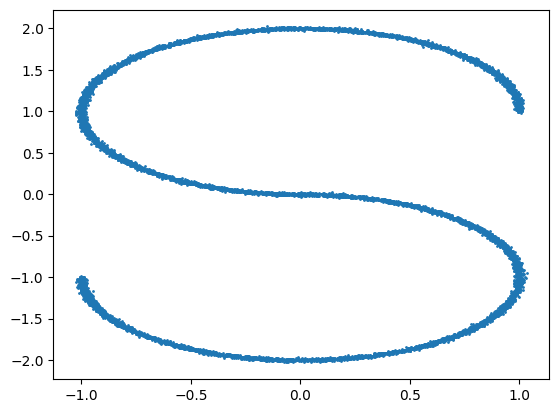

In [3]:
s_x, s_y = datasets.make_s_curve(n_samples=10000, noise=0.01)
s_x = s_x[:, [0, 2]]
plt.scatter(s_x[:, 0], s_x[:, 1], s=1);

In [4]:
class Dataset2d:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]


class Generator2d(nn.Module):
    def __init__(self, lat_size):
        super().__init__()
        self.lat_size = lat_size

        self.net = nn.Sequential(
            nn.Linear(lat_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)


class Discriminator2d(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [5]:
# создадим сети, оптимизаторы, прайор и даталоадер

tr_dataloader_2d = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(s_x, dtype=torch.float32), torch.tensor(s_y)),
    batch_size=64,
    shuffle=True,
    num_workers=64,
)

gen_2d = Generator2d(2)
gen_2d.to(device)

discr_2d = Discriminator2d()
discr_2d.to(device)

prior_2d = torch.distributions.Normal(
    torch.zeros(2).to(device), torch.ones(2).to(device)
)

gen_opt_2d = optim.Adam(gen_2d.parameters(), lr=3e-4)
discr_opt_2d = optim.Adam(discr_2d.parameters(), lr=3e-4, betas=(0.9, 0.999))

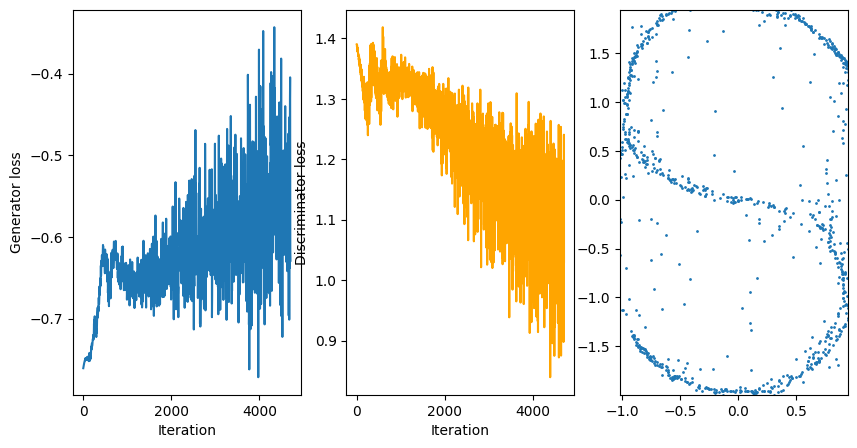

In [6]:
train_gan(
    tr_dataloader_2d,
    gen_2d,
    discr_2d,
    gen_opt_2d,
    discr_opt_2d,
    gan_loss,
    prior_2d,
    num_epochs=30,
    gen_steps=1,
    discr_steps=3,
    verbose_num_iters=10,
)

Визуализируем распределение, которое выучил генератор.

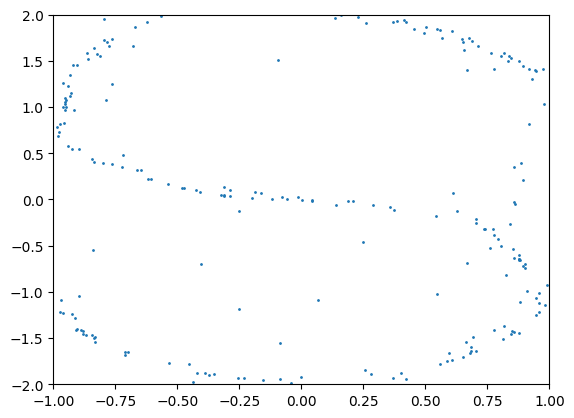

In [7]:
z = prior_2d.sample((256,))

sampled_2d = gen_2d(z)

plt.xlim(-1, 1)
plt.ylim(-2, 2)

plt.scatter(
    sampled_2d[:, 0].cpu().detach().numpy(),
    sampled_2d[:, 1].cpu().detach().numpy(),
    s=1,
);

2d данные отлично подходят и для демонстрации слабых мест GAN'ов: когда данные состоят из нескольких мод (кластеров), ганы подверждены двум сценариям.

1. Mode collapse: ситуация, когда GAN игнорирует часть кластеров и не пытается их выучить.
2. Смешение мод: когда GAN соединяется две моды перешейком. Этот случай, как правило, решается взятием более мощного дискриминатора и генератора.

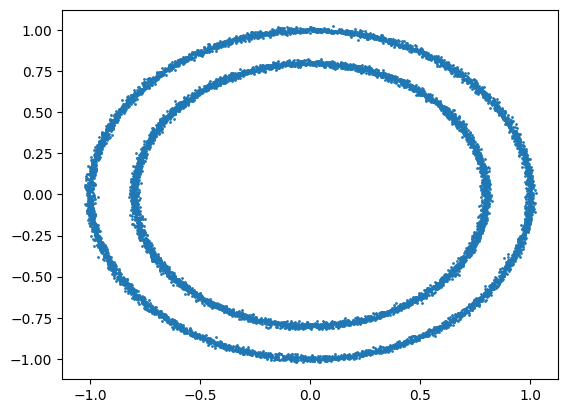

In [8]:
circle_x, circle_y = datasets.make_circles(n_samples=10000, noise=0.01)
plt.scatter(circle_x[:, 0], circle_x[:, 1], s=1);

In [9]:
tr_dataloader_circle = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(circle_x, dtype=torch.float32), torch.tensor(circle_y)),
    batch_size=64,
    shuffle=True,
    num_workers=64,
)

gen_circle = Generator2d(2)
gen_circle.to(device)

discr_circle = Discriminator2d()
discr_circle.to(device)

prior_circle = torch.distributions.Normal(
    torch.zeros(2).to(device), torch.ones(2).to(device)
)

gen_opt_circle = optim.Adam(gen_circle.parameters(), lr=3e-4)
discr_opt_circle = optim.Adam(discr_circle.parameters(), lr=3e-4, betas=(0.9, 0.999))

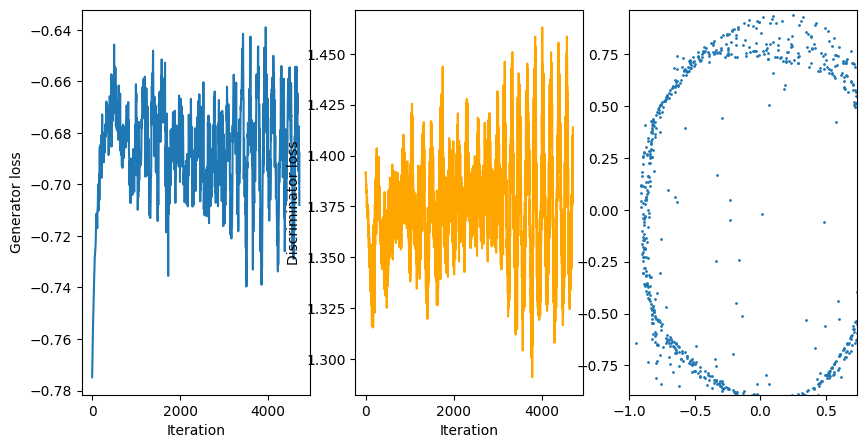

In [10]:
train_gan(
    tr_dataloader_circle,
    gen_circle,
    discr_circle,
    gen_opt_circle,
    discr_opt_circle,
    gan_loss,
    prior_circle,
    num_epochs=30,
    gen_steps=1,
    discr_steps=3,
    verbose_num_iters=10,
)

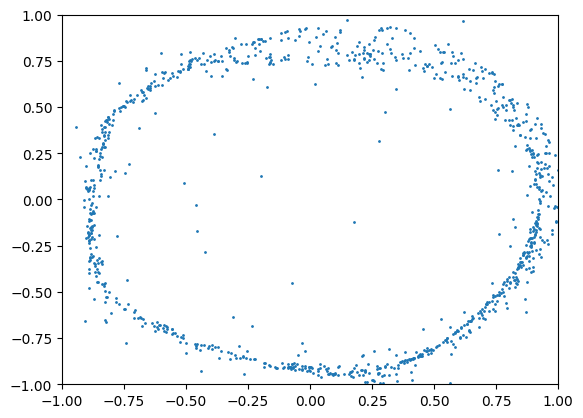

In [11]:
z = prior_circle.sample((1024,))

sampled_circle = gen_circle(z)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.scatter(
    sampled_circle[:, 0].cpu().detach().numpy(),
    sampled_circle[:, 1].cpu().detach().numpy(),
    s=1,
)

## 2. Vanilla GAN: MNIST

Теперь давайте обучим ту же самую архитектуру на чуть-чуть более серьёзные данных. Попробуем генерировать цифры из датасета MNIST.

In [12]:
class GeneratorMNIST(nn.Module):
    def __init__(self, lat_size, hidden=64):
        super().__init__()
        self.lat_size = lat_size

        self.net = nn.Sequential(
            nn.Linear(lat_size, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2 * hidden),
            nn.BatchNorm1d(2 * hidden),
            nn.ReLU(),
            nn.Linear(2 * hidden, 4 * hidden),
            nn.BatchNorm1d(4 * hidden),
            nn.ReLU(),
            nn.Linear(4 * hidden, 32 * 32),
            nn.Tanh(),
        )

    def forward(
        self, z: torch.Tensor, y: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        return self.net(z).view(-1, 1, 32, 32)


class DiscriminatorMNIST(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(32 * 32, 4 * hidden),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(4 * hidden, 2 * hidden),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(2 * hidden, hidden),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden, 1),
        )

    def forward(
        self, x: torch.Tensor, y: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        res = self.net(x.view(-1, 32 * 32))
        res = torch.sigmoid(res)
        return res

In [13]:
transform = transforms.Compose(
    [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

trainset = MNIST(root="./data/", train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=64, pin_memory=True
)

In [14]:
gen_mnist = GeneratorMNIST(100)
gen_mnist.to(device)

discr_mnist = DiscriminatorMNIST()
discr_mnist.to(device)

prior_mnist = torch.distributions.Normal(
    torch.zeros(100).to(device), torch.ones(100).to(device)
)

gen_opt_mnist = optim.Adam(gen_mnist.parameters(), lr=3e-4)
discr_opt_mnist = optim.Adam(discr_mnist.parameters(), lr=3e-4, betas=(0.5, 0.999))

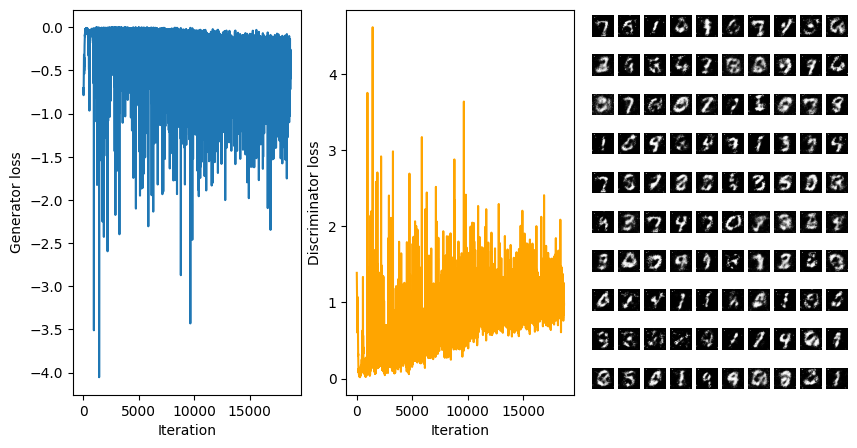

In [15]:
train_gan(
    trainloader_mnist,
    gen_mnist,
    discr_mnist,
    gen_opt_mnist,
    discr_opt_mnist,
    gan_loss,
    prior_mnist,
    num_epochs=20,
    gen_steps=1,
    discr_steps=1,
    verbose_num_iters=100,
    data_type="mnist",
)

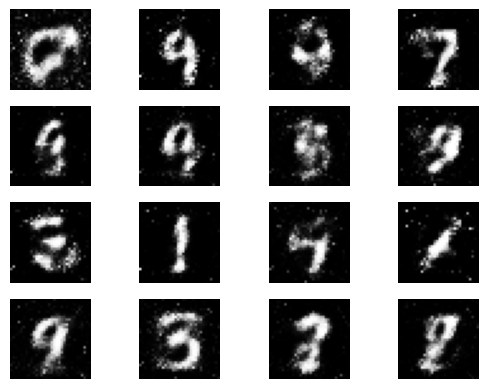

In [16]:
z = prior_mnist.sample((16,))

sampled_mnist = gen_mnist(z)

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap="gray")

Получается, в общем-то, более менее недурно!

## 3. GAN: Fashion MNIST

### 3.1 Имплементируем работающее решение

In [17]:
class SimpleDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = self.fc4(x)

        return x


class SimpleGenerator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc3 = nn.Linear(hidden_dim * 4, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.tanh(x)

        return x

In [18]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 28 * 28
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 28 * 28
# Size of *first* hidden layer in the generator
g_hidden_size = 32

In [19]:
# instantiate discriminator and generator
D = SimpleDiscriminator(input_size, d_hidden_size, d_output_size)
G = SimpleGenerator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

SimpleDiscriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

SimpleGenerator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [20]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss


def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

In [21]:
lr = 0.002

d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [22]:
training_data = torchvision.datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transforms.ToTensor()
)

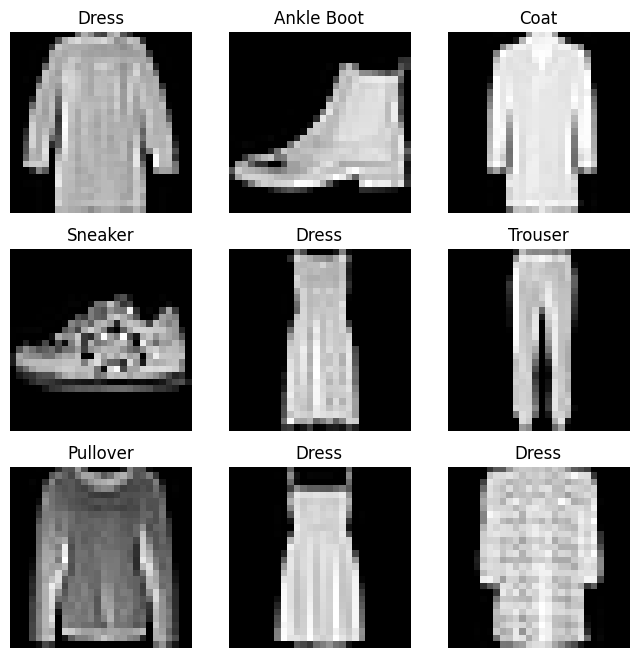

In [23]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [24]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, num_workers=64)

In [25]:
D = SimpleDiscriminator(input_size, d_hidden_size, d_output_size)
G = SimpleGenerator(z_size, g_hidden_size, g_output_size)
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [26]:
num_epochs = 40

samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)

        ## Important rescaling step ##
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)

        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        # 1. Train with real images
        d_optimizer.zero_grad()

        # Compute the discriminator losses on real images
        # use smoothed labels
        op_real = D(real_images)
        d_real_loss = real_loss(op_real, smooth=True)

        # 2. Train with fake images

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        op_fake = D(fake_images)
        d_fake_loss = fake_loss(op_fake)

        # add up real and fake losses and perform backprop
        d_loss = d_fake_loss + d_real_loss
        d_loss.backward()
        d_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================

        # 1. Train with fake images and flipped labels
        g_optimizer.zero_grad()

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        # using flipped labels!
        d_fake_loss = D(fake_images)
        g_loss = real_loss(d_fake_loss)

        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print(
                "Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}".format(
                    epoch + 1, num_epochs, d_loss.item(), g_loss.item()
                )
            )

    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval()  # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()  # back to train mode

Epoch [    1/   40] | d_loss: 1.3871 | g_loss: 0.6714
Epoch [    1/   40] | d_loss: 0.5716 | g_loss: 4.2296
Epoch [    1/   40] | d_loss: 1.0173 | g_loss: 2.2043
Epoch [    2/   40] | d_loss: 0.6037 | g_loss: 3.1283
Epoch [    2/   40] | d_loss: 1.2408 | g_loss: 3.0795
Epoch [    2/   40] | d_loss: 0.8658 | g_loss: 1.9276
Epoch [    3/   40] | d_loss: 0.9594 | g_loss: 2.0318
Epoch [    3/   40] | d_loss: 1.1814 | g_loss: 1.6483
Epoch [    3/   40] | d_loss: 1.1487 | g_loss: 1.5397
Epoch [    4/   40] | d_loss: 1.0928 | g_loss: 1.2156
Epoch [    4/   40] | d_loss: 1.1232 | g_loss: 1.5425
Epoch [    4/   40] | d_loss: 1.3228 | g_loss: 0.9549
Epoch [    5/   40] | d_loss: 1.1913 | g_loss: 1.6241
Epoch [    5/   40] | d_loss: 1.3502 | g_loss: 1.1691
Epoch [    5/   40] | d_loss: 1.3321 | g_loss: 0.8726
Epoch [    6/   40] | d_loss: 1.1808 | g_loss: 1.3190
Epoch [    6/   40] | d_loss: 1.1955 | g_loss: 1.7653
Epoch [    6/   40] | d_loss: 1.1556 | g_loss: 1.0861
Epoch [    7/   40] | d_loss

In [ ]:
from tqdm import tqdm

figs = []

for l in tqdm(range(0, len(samples), 5)):
    step = 0
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(
                samples[l][step].reshape(28, 28).detach().numpy(), cmap="Greys_r"
            )
            step += 1
    figs.append(fig)

## 3.2 Изучаем неработающее решение

Давайте теперь попробуем более сложную модель, которую использовали на картинках 64х64 и интерьерами квартир в этой [статье](https://arxiv.org/abs/1511.06434). 

In [27]:
class ConvGenerator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.seq = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(input_size, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 1, 2, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], 1, 1)
        x = self.seq(x)

        return x


class ConvDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4, 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 1, 4, 2, 1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.seq(x)

        return x

In [28]:
D = ConvDiscriminator()
G = ConvGenerator(100)
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [29]:
num_epochs = 3

samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):

    for batch_i, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)

        ## Important rescaling step ##
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)

        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        # 1. Train with real images
        d_optimizer.zero_grad()

        # Compute the discriminator losses on real images
        # use smoothed labels
        op_real = D(real_images)
        d_real_loss = real_loss(op_real, smooth=True)

        # 2. Train with fake images

        # Generate fake images
        z = torch.randn(batch_size, z_size)
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        op_fake = D(fake_images)
        d_fake_loss = fake_loss(op_fake)

        # add up real and fake losses and perform backprop
        d_loss = d_fake_loss + d_real_loss
        d_loss.backward()
        d_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================

        # 1. Train with fake images and flipped labels
        g_optimizer.zero_grad()

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        # using flipped labels!
        d_fake_loss = D(fake_images)
        g_loss = real_loss(d_fake_loss)

        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print(
                "Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}".format(
                    epoch + 1, num_epochs, d_loss.item(), g_loss.item()
                )
            )

    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval()  # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()  # back to train mode

Epoch [    1/    3] | d_loss: 1.4867 | g_loss: 0.4987
Epoch [    1/    3] | d_loss: 1.1084 | g_loss: 0.6915
Epoch [    1/    3] | d_loss: 1.1066 | g_loss: 0.6931
Epoch [    2/    3] | d_loss: 1.1064 | g_loss: 0.6931
Epoch [    2/    3] | d_loss: 1.1064 | g_loss: 0.6931
Epoch [    2/    3] | d_loss: 1.1064 | g_loss: 0.6931
Epoch [    3/    3] | d_loss: 1.1064 | g_loss: 0.6931
Epoch [    3/    3] | d_loss: 1.1064 | g_loss: 0.6931
Epoch [    3/    3] | d_loss: 1.1064 | g_loss: 0.6931


  0%|          | 0/3 [00:00<?, ?it/s]

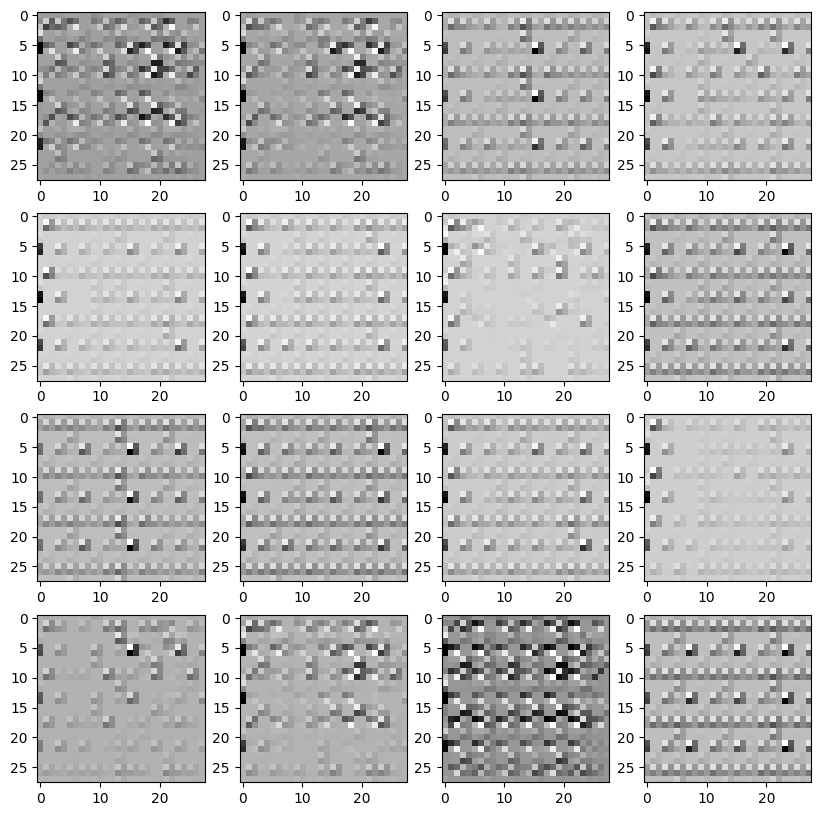

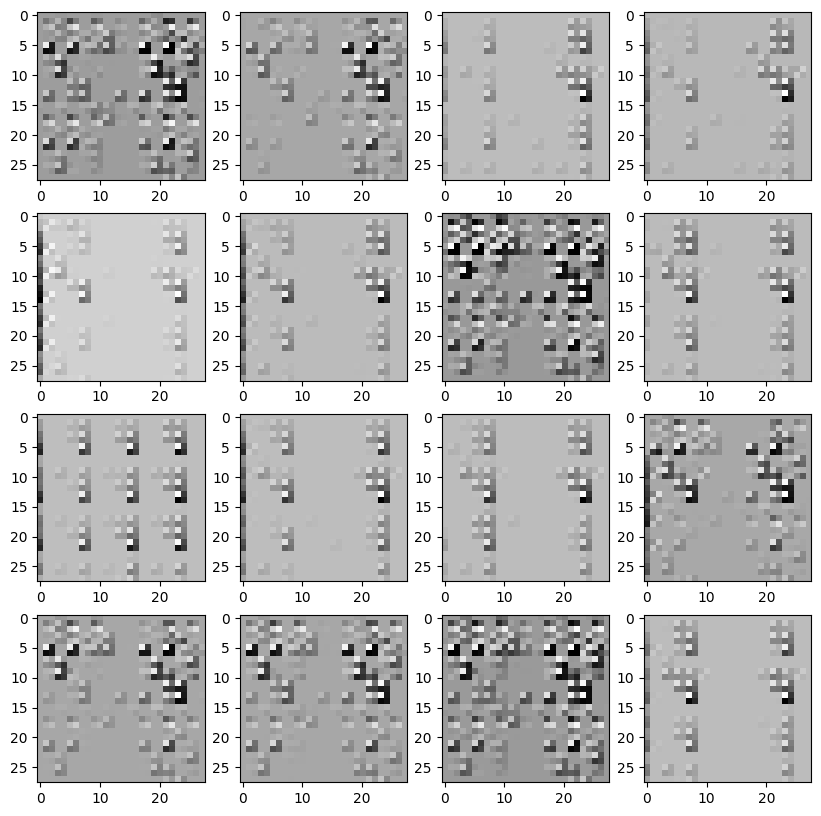

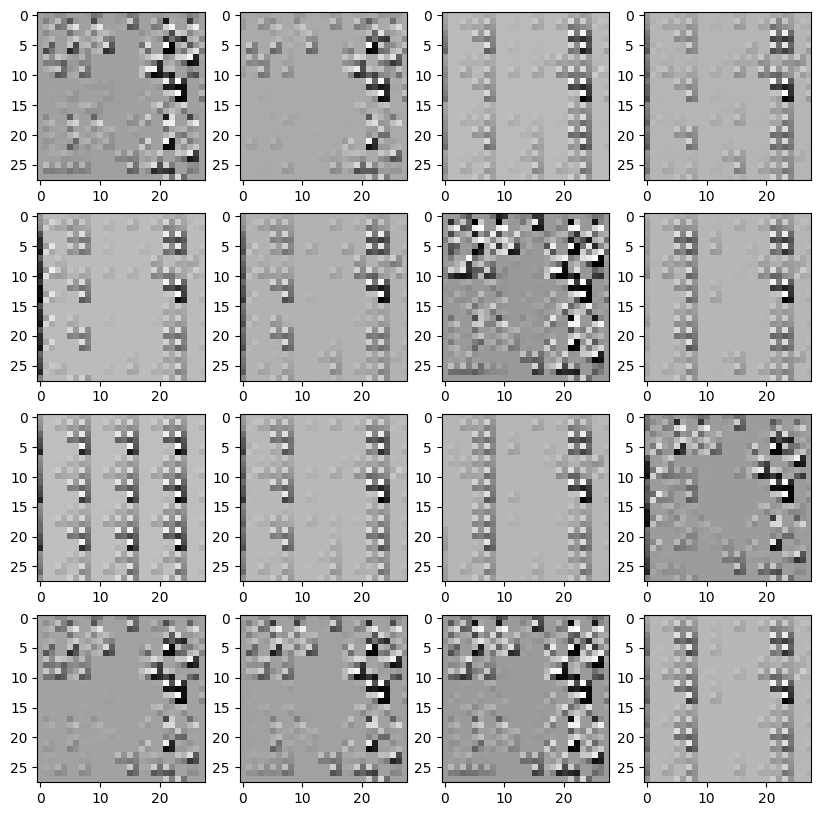

In [30]:
figs = []

for l in tqdm(range(0, len(samples))):
    step = 0
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(
                samples[l][step].reshape(28, 28).detach().numpy(), cmap="Greys_r"
            )
            step += 1
    figs.append(fig)

В этом случае у нас ничего не выходит, потому что данные очень простые, а дискриминатор довольно сильный. В итоге дискриминатор быстро учится различать настоящие данные и фейки, а генератор не учится.